TRAINING MC DROPOUT MODEL


C:\Users\nithi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Performing MC Dropout (100 iterations)...
MC Dropout - RMSE: 5.7048, MAE: 3.9858

TRAINING VARIATIONAL INFERENCE MODEL
Performing VI sampling (100 iterations)...
VI - RMSE: 7.6818, MAE: 5.7275

TRAINING PROBABILISTIC BACKPROPAGATION MODEL
Performing PBP sampling (100 iterations)...
PBP - RMSE: 7.0433, MAE: 5.4120

COMPARISON TABLE: PBP vs VI vs MC DROPOUT
    Method Avg Test RMSE RMSE Std Error Avg Test LL LL Std Error    MAE Accuracy (%) Avg Predicted Uncertainty
       PBP        7.0433         0.3655     -4.0578       0.1959 5.4120        39.32                    3.4235
        VI        7.6818         0.3423     -4.3328       0.3390 5.7275        34.95                    3.6854
MC Dropout        5.7048         0.3248     -4.5120       0.3456 3.9858        57.28                    2.3934

Comparison table saved to 'uncertainty_methods_comparison.csv'

Generating MC Dropout plots...
Training Standard Model for comparison...


C:\Users\nithi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generating Standard vs MC Dropout comparison plots...


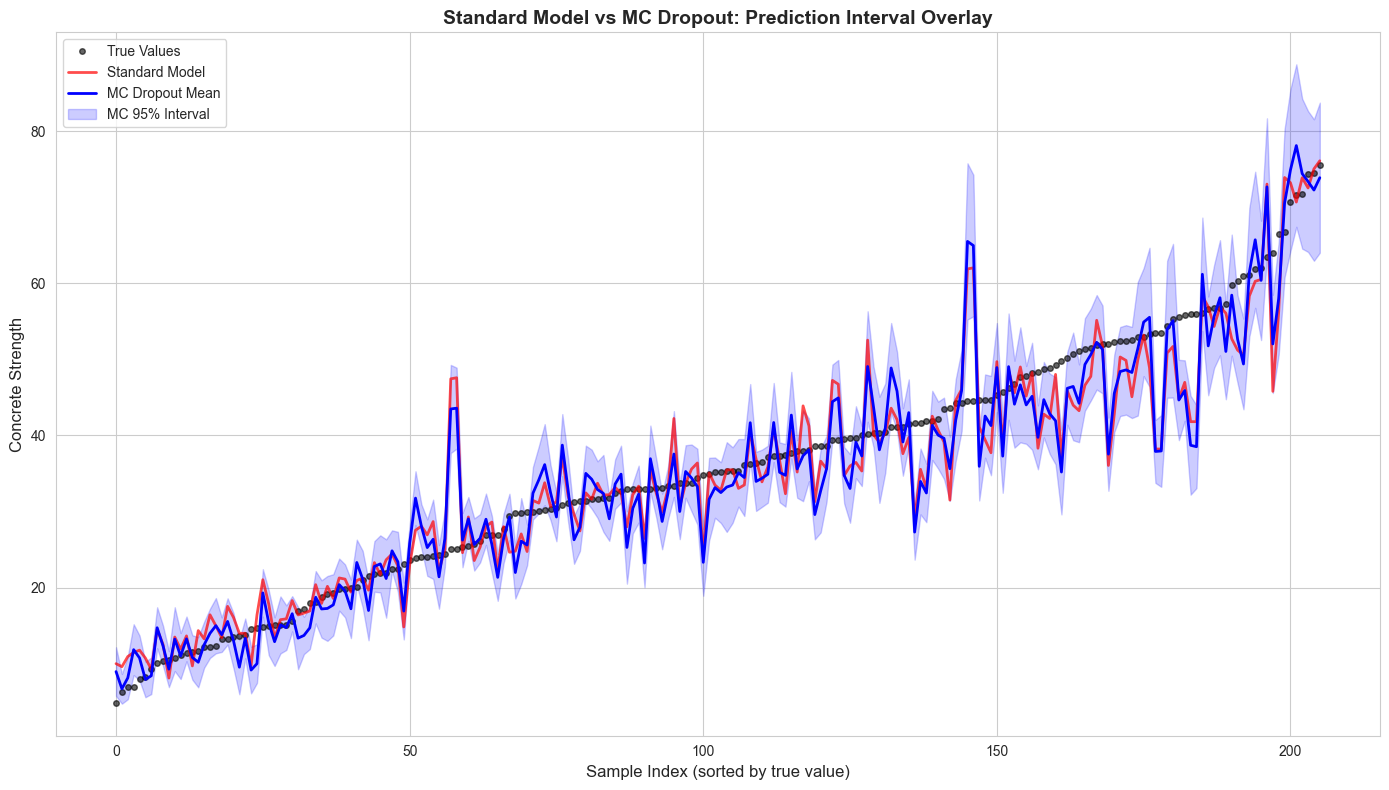

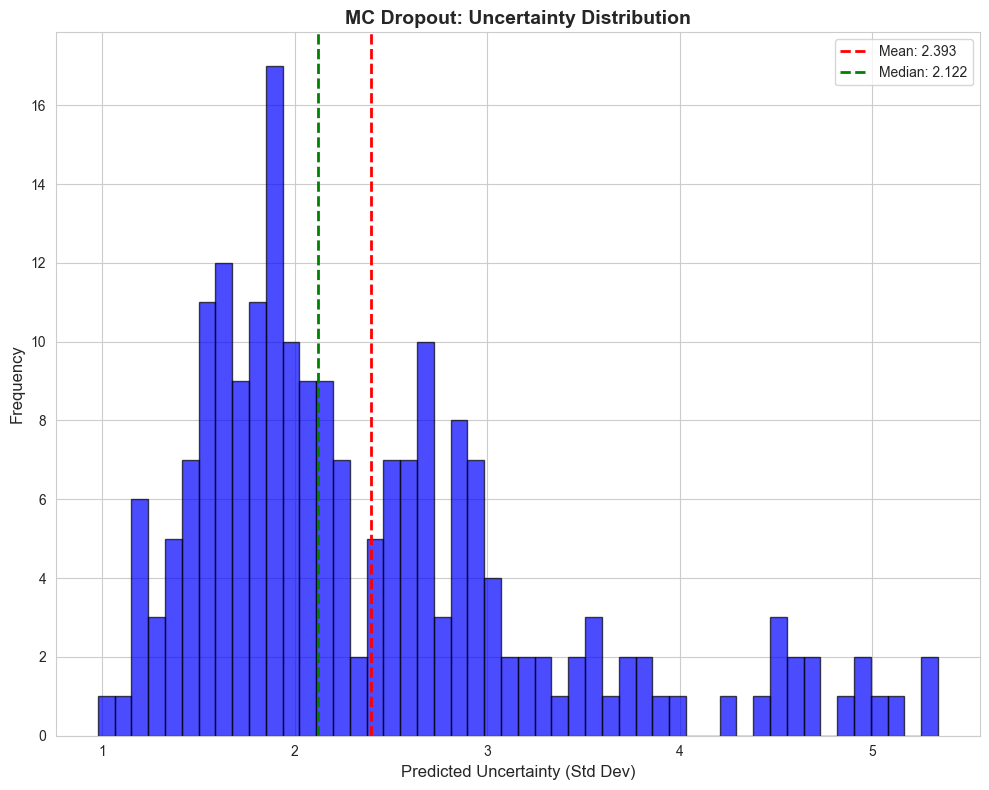

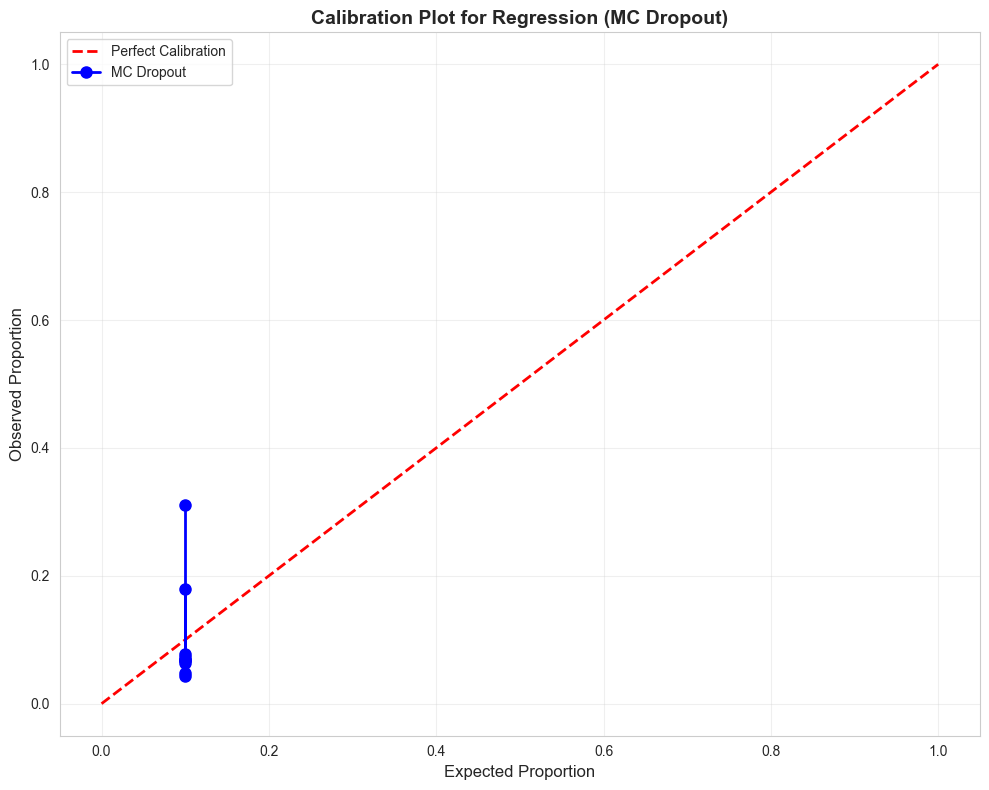

Generating MC vs VI vs PBP comparison plots...


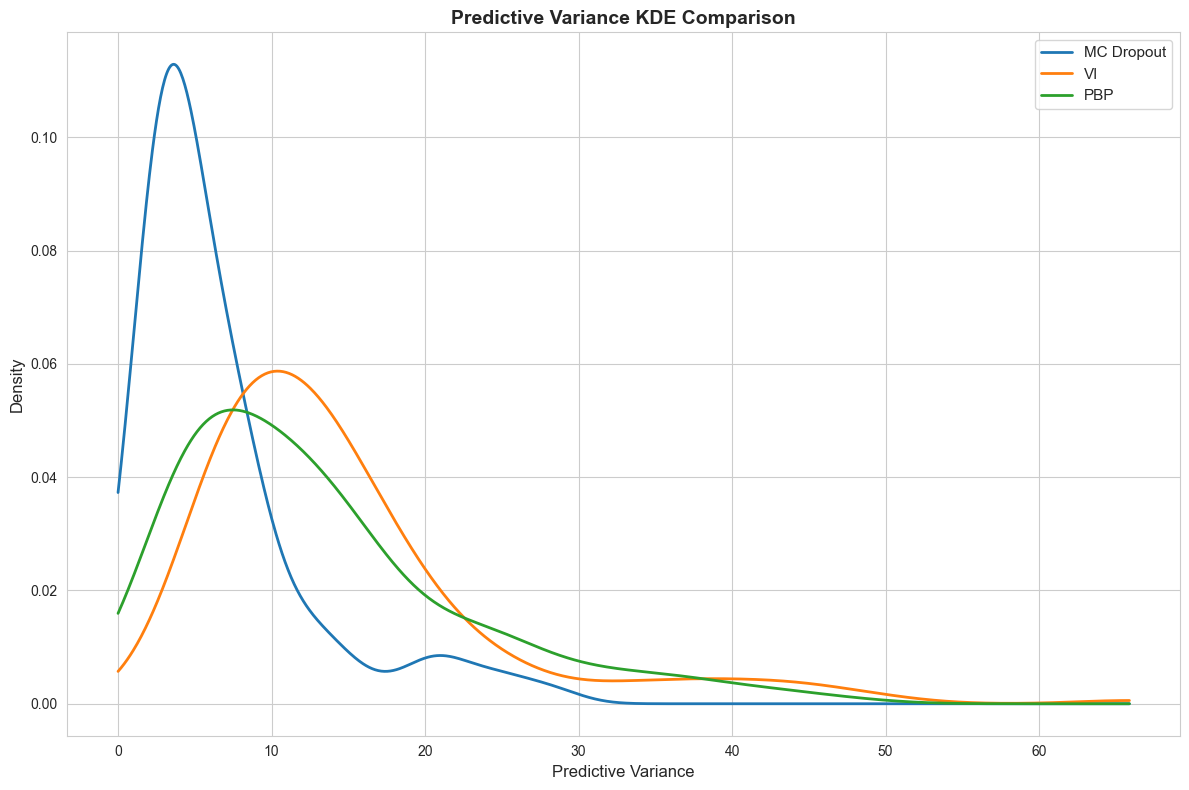

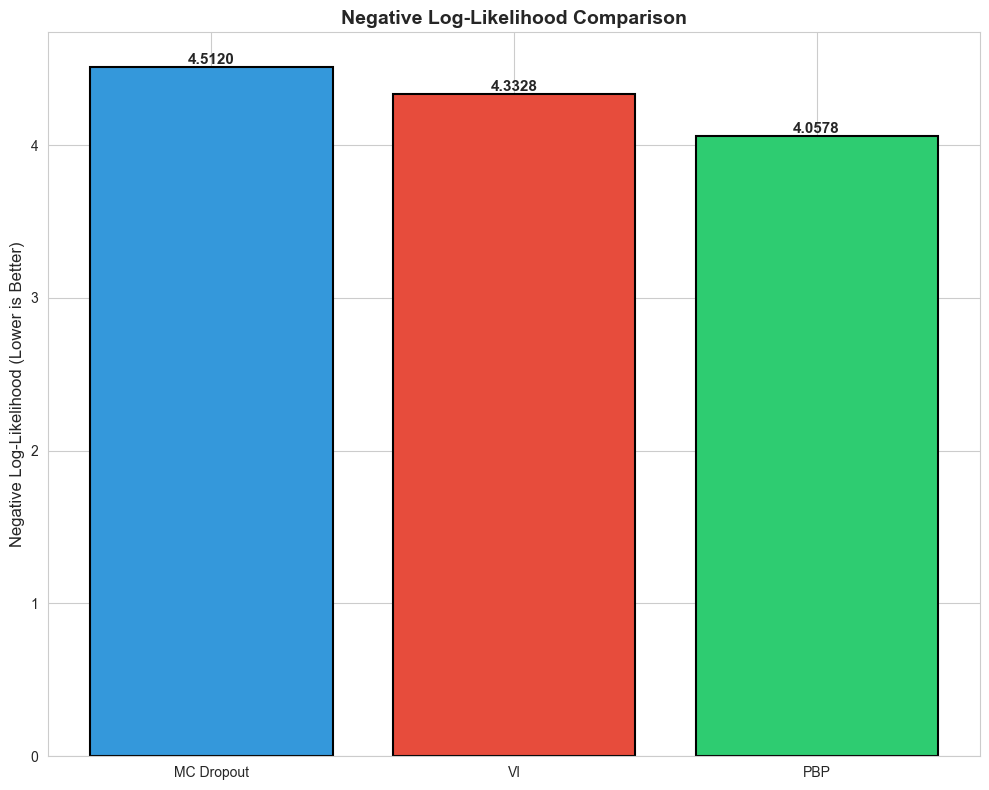

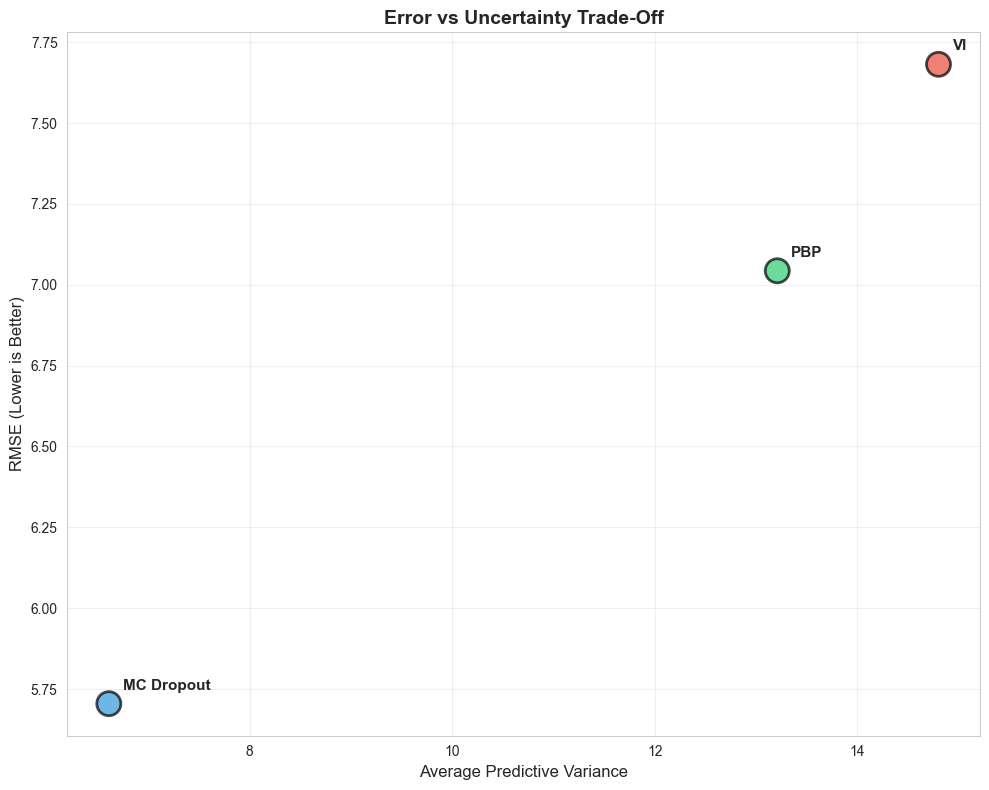

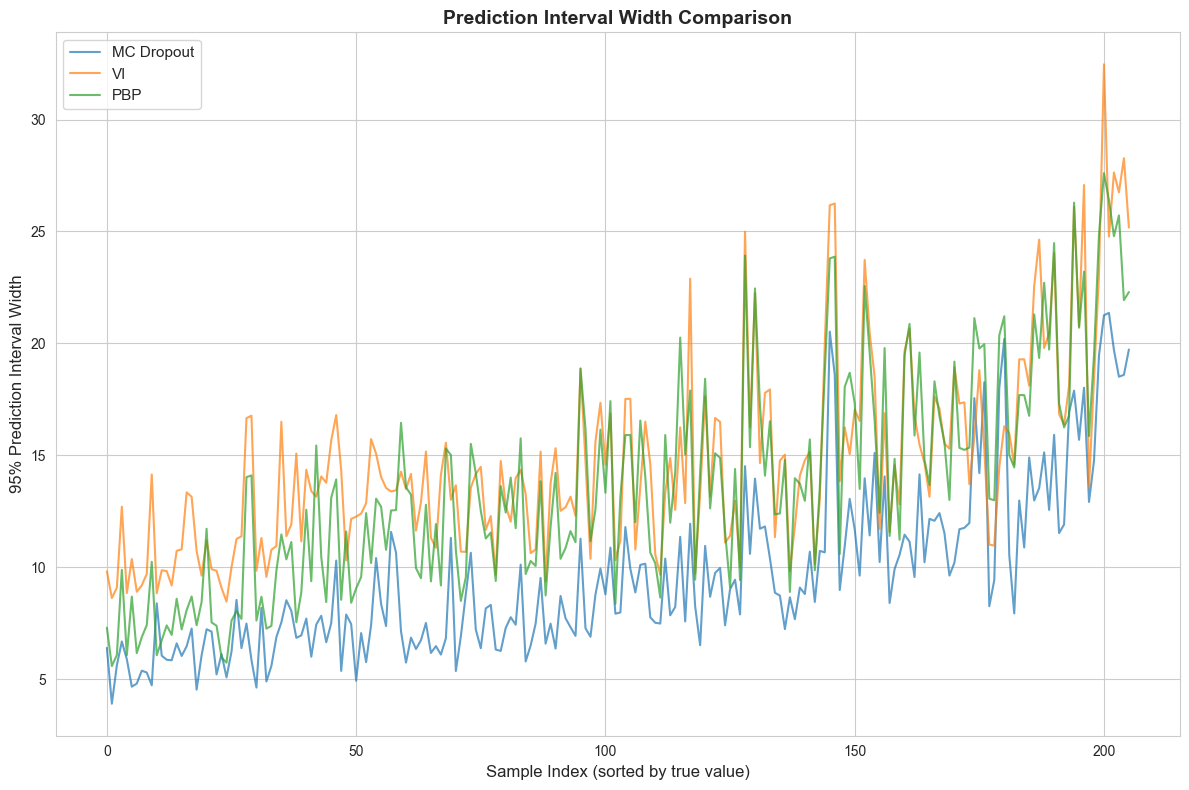

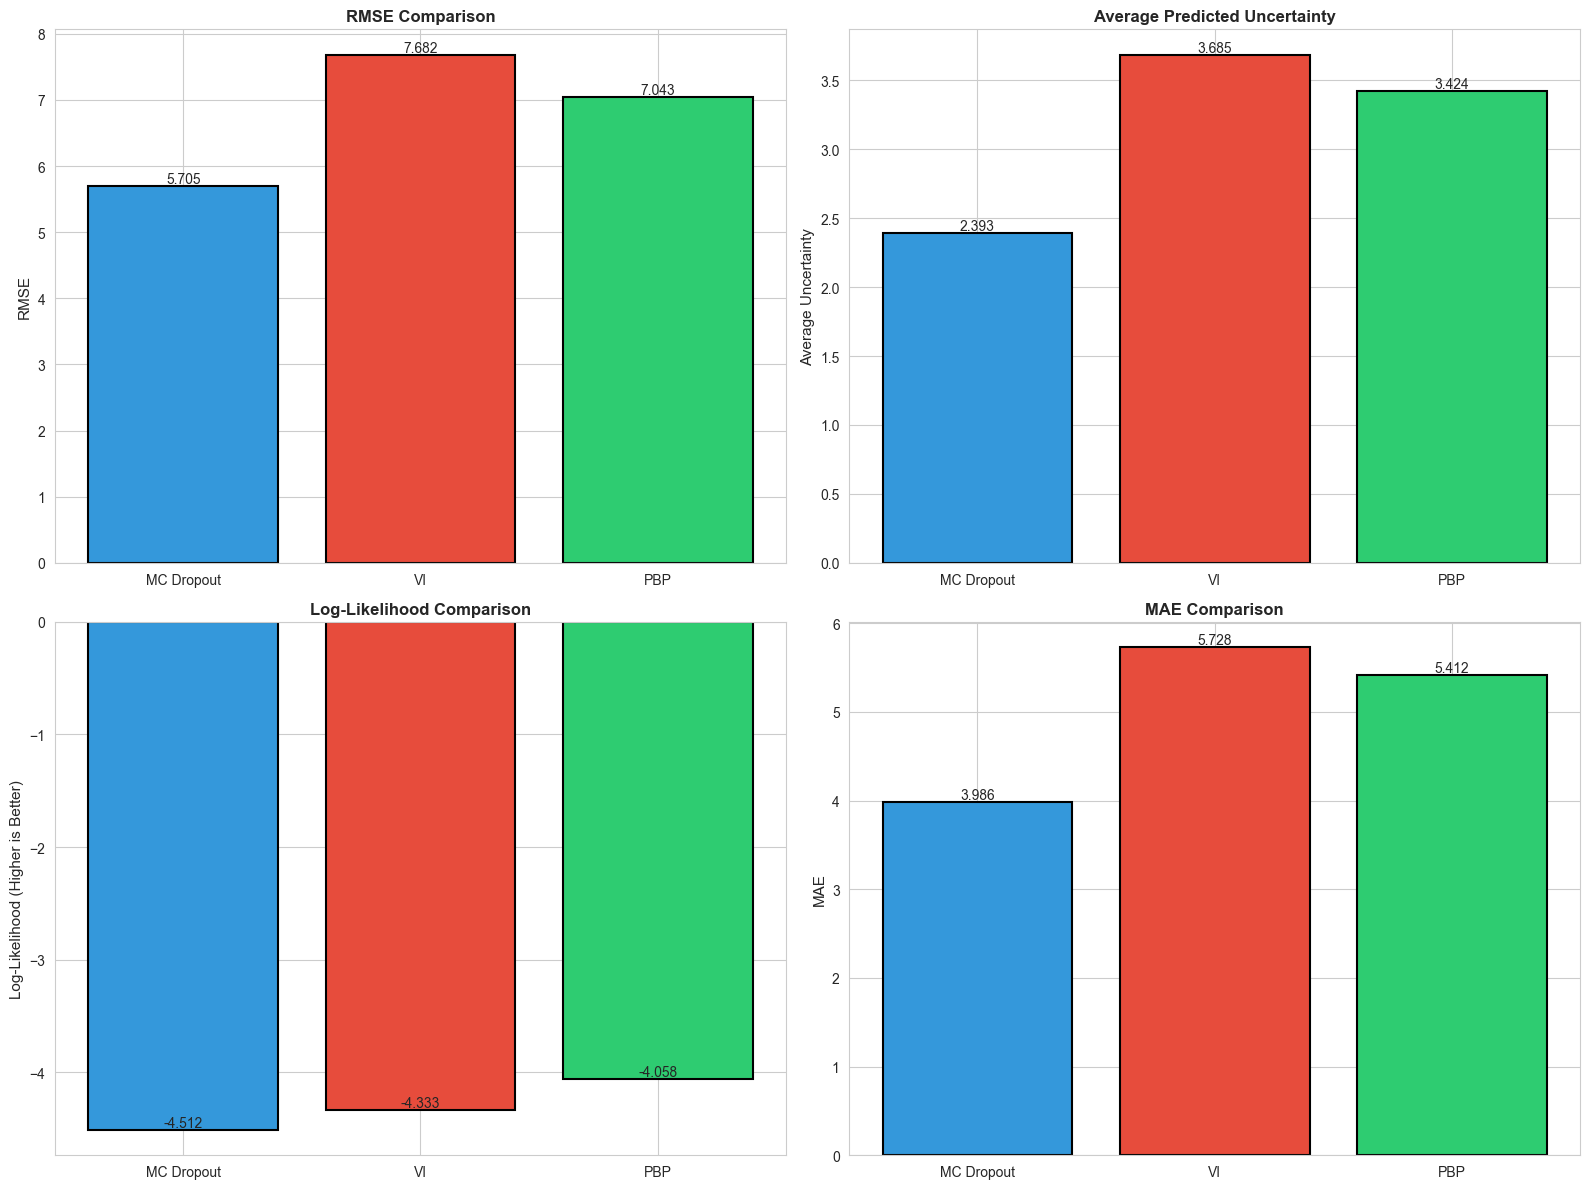

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Load data
df = pd.read_csv(r"C:\Users\nithi\Downloads\archive\concrete_data.csv")

# Separate features and target
X = df.drop('Strength', axis=1)
y = df['Strength']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays
y_train = y_train.values
y_test = y_test.values

# ============== MC DROPOUT MODEL ==============
print("="*60)
print("TRAINING MC DROPOUT MODEL")
print("="*60)

mc_model = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

mc_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
mc_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# MC Dropout predictions
print("Performing MC Dropout (100 iterations)...")
n_iterations = 100
mc_predictions = []
for i in range(n_iterations):
    y_pred_mc = mc_model(X_test_scaled, training=True).numpy().flatten()
    mc_predictions.append(y_pred_mc)

mc_predictions = np.array(mc_predictions)
mc_mean = np.mean(mc_predictions, axis=0)
mc_std = np.std(mc_predictions, axis=0)
mc_var = np.var(mc_predictions, axis=0)

# MC metrics
mc_rmse = np.sqrt(mean_squared_error(y_test, mc_mean))
mc_mae = mean_absolute_error(y_test, mc_mean)
mc_accuracy = np.mean(np.abs((y_test - mc_mean) / y_test) <= 0.1) * 100
mc_avg_uncertainty = np.mean(mc_std)

# Log likelihood for MC (Gaussian)
mc_ll = np.mean(-0.5 * np.log(2 * np.pi * (mc_var + 1e-6)) - 0.5 * ((y_test - mc_mean) ** 2) / (mc_var + 1e-6))

print(f"MC Dropout - RMSE: {mc_rmse:.4f}, MAE: {mc_mae:.4f}")

# ============== VARIATIONAL INFERENCE (VI) MODEL ==============
print("\n" + "="*60)
print("TRAINING VARIATIONAL INFERENCE MODEL")
print("="*60)

class BayesianDense(layers.Layer):
    def __init__(self, units, kl_weight):
        super(BayesianDense, self).__init__()
        self.units = units
        self.kl_weight = kl_weight
        
    def build(self, input_shape):
        # Weight posterior parameters
        self.w_mu = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='w_mu'
        )
        self.w_rho = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.constant_initializer(-3.0),
            trainable=True,
            name='w_rho'
        )
        
        # Bias posterior parameters
        self.b_mu = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='b_mu'
        )
        self.b_rho = self.add_weight(
            shape=(self.units,),
            initializer=tf.constant_initializer(-3.0),
            trainable=True,
            name='b_rho'
        )
        
    def call(self, inputs):
        # Sample weights and biases
        w_sigma = tf.nn.softplus(self.w_rho)
        b_sigma = tf.nn.softplus(self.b_rho)
        
        w_epsilon = tf.random.normal(shape=self.w_mu.shape)
        b_epsilon = tf.random.normal(shape=self.b_mu.shape)
        
        w = self.w_mu + w_sigma * w_epsilon
        b = self.b_mu + b_sigma * b_epsilon
        
        # KL divergence (posterior || prior)
        # Prior: N(0, 1)
        w_kl = 0.5 * tf.reduce_sum(
            self.w_mu**2 + w_sigma**2 - tf.math.log(w_sigma**2 + 1e-8) - 1
        )
        b_kl = 0.5 * tf.reduce_sum(
            self.b_mu**2 + b_sigma**2 - tf.math.log(b_sigma**2 + 1e-8) - 1
        )
        
        self.add_loss(self.kl_weight * (w_kl + b_kl))
        
        return tf.matmul(inputs, w) + b

# Build VI model
kl_weight = 1.0 / len(X_train_scaled)
inputs = layers.Input(shape=(X_train_scaled.shape[1],))
x = BayesianDense(1024, kl_weight)(inputs)
x = layers.Activation('relu')(x)
x = BayesianDense(1024, kl_weight)(x)
x = layers.Activation('relu')(x)
x = BayesianDense(1024, kl_weight)(x)
x = layers.Activation('relu')(x)
x = BayesianDense(1024, kl_weight)(x)
x = layers.Activation('relu')(x)
x = BayesianDense(1024, kl_weight)(x)
x = layers.Activation('relu')(x)
outputs = BayesianDense(1, kl_weight)(x)

vi_model = models.Model(inputs=inputs, outputs=outputs)
vi_model.compile(optimizer='adam', loss='mse')
vi_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# VI predictions
print("Performing VI sampling (100 iterations)...")
vi_predictions = []
for i in range(n_iterations):
    y_pred_vi = vi_model(X_test_scaled, training=True).numpy().flatten()
    vi_predictions.append(y_pred_vi)

vi_predictions = np.array(vi_predictions)
vi_mean = np.mean(vi_predictions, axis=0)
vi_std = np.std(vi_predictions, axis=0)
vi_var = np.var(vi_predictions, axis=0)

# VI metrics
vi_rmse = np.sqrt(mean_squared_error(y_test, vi_mean))
vi_mae = mean_absolute_error(y_test, vi_mean)
vi_accuracy = np.mean(np.abs((y_test - vi_mean) / y_test) <= 0.1) * 100
vi_avg_uncertainty = np.mean(vi_std)

# Log likelihood for VI
vi_ll = np.mean(-0.5 * np.log(2 * np.pi * (vi_var + 1e-6)) - 0.5 * ((y_test - vi_mean) ** 2) / (vi_var + 1e-6))

print(f"VI - RMSE: {vi_rmse:.4f}, MAE: {vi_mae:.4f}")

# ============== PROBABILISTIC BACKPROPAGATION (PBP) ==============
print("\n" + "="*60)
print("TRAINING PROBABILISTIC BACKPROPAGATION MODEL")
print("="*60)

class PBPLayer(layers.Layer):
    def __init__(self, units):
        super(PBPLayer, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.w_mean = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='w_mean'
        )
        self.w_log_var = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.constant_initializer(-6.0),
            trainable=True,
            name='w_log_var'
        )
        self.b_mean = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='b_mean'
        )
        self.b_log_var = self.add_weight(
            shape=(self.units,),
            initializer=tf.constant_initializer(-6.0),
            trainable=True,
            name='b_log_var'
        )
        
    def call(self, inputs, training=False):
        if training:
            w = self.w_mean + tf.exp(0.5 * self.w_log_var) * tf.random.normal(shape=self.w_mean.shape)
            b = self.b_mean + tf.exp(0.5 * self.b_log_var) * tf.random.normal(shape=self.b_mean.shape)
        else:
            w = self.w_mean
            b = self.b_mean
        return tf.matmul(inputs, w) + b

pbp_model = models.Sequential([
    PBPLayer(1024),
    layers.Activation('relu'),
    PBPLayer(1024),
    layers.Activation('relu'),
    PBPLayer(1024),
    layers.Activation('relu'),
    PBPLayer(1024),
    layers.Activation('relu'),
    PBPLayer(1024),
    layers.Activation('relu'),
    PBPLayer(1)
])

pbp_model.compile(optimizer='adam', loss='mse')
pbp_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# PBP predictions
print("Performing PBP sampling (100 iterations)...")
pbp_predictions = []
for i in range(n_iterations):
    y_pred_pbp = pbp_model(X_test_scaled, training=True).numpy().flatten()
    pbp_predictions.append(y_pred_pbp)

pbp_predictions = np.array(pbp_predictions)
pbp_mean = np.mean(pbp_predictions, axis=0)
pbp_std = np.std(pbp_predictions, axis=0)
pbp_var = np.var(pbp_predictions, axis=0)

# PBP metrics
pbp_rmse = np.sqrt(mean_squared_error(y_test, pbp_mean))
pbp_mae = mean_absolute_error(y_test, pbp_mean)
pbp_accuracy = np.mean(np.abs((y_test - pbp_mean) / y_test) <= 0.1) * 100
pbp_avg_uncertainty = np.mean(pbp_std)

# Log likelihood for PBP
pbp_ll = np.mean(-0.5 * np.log(2 * np.pi * (pbp_var + 1e-6)) - 0.5 * ((y_test - pbp_mean) ** 2) / (pbp_var + 1e-6))

print(f"PBP - RMSE: {pbp_rmse:.4f}, MAE: {pbp_mae:.4f}")

# ============== COMPARISON TABLE ==============
print("\n" + "="*80)
print("COMPARISON TABLE: PBP vs VI vs MC DROPOUT")
print("="*80)

# Calculate standard errors (across bootstrap samples)
n_bootstrap = 5
mc_rmse_list, vi_rmse_list, pbp_rmse_list = [], [], []
mc_ll_list, vi_ll_list, pbp_ll_list = [], [], []

for _ in range(n_bootstrap):
    indices = np.random.choice(len(y_test), len(y_test), replace=True)
    
    # MC bootstrap
    mc_rmse_list.append(np.sqrt(mean_squared_error(y_test[indices], mc_mean[indices])))
    mc_ll_list.append(np.mean(-0.5 * np.log(2 * np.pi * (mc_var[indices] + 1e-6)) - 
                               0.5 * ((y_test[indices] - mc_mean[indices]) ** 2) / (mc_var[indices] + 1e-6)))
    
    # VI bootstrap
    vi_rmse_list.append(np.sqrt(mean_squared_error(y_test[indices], vi_mean[indices])))
    vi_ll_list.append(np.mean(-0.5 * np.log(2 * np.pi * (vi_var[indices] + 1e-6)) - 
                               0.5 * ((y_test[indices] - vi_mean[indices]) ** 2) / (vi_var[indices] + 1e-6)))
    
    # PBP bootstrap
    pbp_rmse_list.append(np.sqrt(mean_squared_error(y_test[indices], pbp_mean[indices])))
    pbp_ll_list.append(np.mean(-0.5 * np.log(2 * np.pi * (pbp_var[indices] + 1e-6)) - 
                                0.5 * ((y_test[indices] - pbp_mean[indices]) ** 2) / (pbp_var[indices] + 1e-6)))

mc_rmse_se = np.std(mc_rmse_list)
mc_ll_se = np.std(mc_ll_list)
vi_rmse_se = np.std(vi_rmse_list)
vi_ll_se = np.std(vi_ll_list)
pbp_rmse_se = np.std(pbp_rmse_list)
pbp_ll_se = np.std(pbp_ll_list)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': ['PBP', 'VI', 'MC Dropout'],
    'Avg Test RMSE': [f'{pbp_rmse:.4f}', f'{vi_rmse:.4f}', f'{mc_rmse:.4f}'],
    'RMSE Std Error': [f'{pbp_rmse_se:.4f}', f'{vi_rmse_se:.4f}', f'{mc_rmse_se:.4f}'],
    'Avg Test LL': [f'{pbp_ll:.4f}', f'{vi_ll:.4f}', f'{mc_ll:.4f}'],
    'LL Std Error': [f'{pbp_ll_se:.4f}', f'{vi_ll_se:.4f}', f'{mc_ll_se:.4f}'],
    'MAE': [f'{pbp_mae:.4f}', f'{vi_mae:.4f}', f'{mc_mae:.4f}'],
    'Accuracy (%)': [f'{pbp_accuracy:.2f}', f'{vi_accuracy:.2f}', f'{mc_accuracy:.2f}'],
    'Avg Predicted Uncertainty': [f'{pbp_avg_uncertainty:.4f}', f'{vi_avg_uncertainty:.4f}', f'{mc_avg_uncertainty:.4f}']
})

print(comparison_df.to_string(index=False))
print("="*80)

# Save to CSV
comparison_df.to_csv('uncertainty_methods_comparison.csv', index=False)
print("\nComparison table saved to 'uncertainty_methods_comparison.csv'")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============== MC DROPOUT PLOTS ==============
print("\nGenerating MC Dropout plots...")

# 1. True vs Predicted Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, mc_mean, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Strength', fontsize=12)
plt.ylabel('Predicted Strength', fontsize=12)
plt.title('MC Dropout: True vs Predicted Scatter Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('mc_dropout_true_vs_pred.png', dpi=300)
plt.close()

# 2. Residuals Plot
residuals_mc = y_test - mc_mean
plt.figure(figsize=(10, 8))
plt.scatter(y_test, residuals_mc, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('True Strength', fontsize=12)
plt.ylabel('Residuals (True - Predicted)', fontsize=12)
plt.title('MC Dropout: Residuals Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mc_dropout_residuals.png', dpi=300)
plt.close()

# 3. Prediction Interval Plot
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
mc_mean_sorted = mc_mean[sorted_indices]
mc_std_sorted = mc_std[sorted_indices]

plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test_sorted)), y_test_sorted, 'ko', markersize=4, label='True Values', alpha=0.6)
plt.plot(range(len(y_test_sorted)), mc_mean_sorted, 'b-', linewidth=2, label='Mean Prediction')
plt.fill_between(range(len(y_test_sorted)), 
                 mc_mean_sorted - 2*mc_std_sorted, 
                 mc_mean_sorted + 2*mc_std_sorted, 
                 alpha=0.3, color='blue', label='95% Prediction Interval')
plt.xlabel('Sample Index (sorted by true value)', fontsize=12)
plt.ylabel('Concrete Strength', fontsize=12)
plt.title('MC Dropout: Prediction Interval Plot (Mean ± 2σ)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('mc_dropout_prediction_interval.png', dpi=300)
plt.close()

# 4. Uncertainty vs Prediction Error
abs_errors_mc = np.abs(residuals_mc)
plt.figure(figsize=(10, 8))
plt.scatter(mc_std, abs_errors_mc, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.xlabel('Predicted Uncertainty (Std Dev)', fontsize=12)
plt.ylabel('Absolute Prediction Error', fontsize=12)
plt.title('MC Dropout: Uncertainty vs Prediction Error', fontsize=14, fontweight='bold')
# Add correlation coefficient
correlation = np.corrcoef(mc_std, abs_errors_mc)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('mc_dropout_uncertainty_vs_error.png', dpi=300)
plt.close()

# ============== STANDARD MODEL (for comparison) ==============
print("Training Standard Model for comparison...")

# Train a standard model without dropout/uncertainty
standard_model = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1)
])

standard_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
standard_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Standard predictions (no uncertainty)
y_pred_standard = standard_model.predict(X_test_scaled, verbose=0).flatten()

# ============== STANDARD vs MC DROPOUT COMPARISON ==============
print("Generating Standard vs MC Dropout comparison plots...")

# 5. Prediction Interval Overlay
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test_sorted)), y_test_sorted, 'ko', markersize=4, label='True Values', alpha=0.6)
y_pred_standard_sorted = y_pred_standard[sorted_indices]
plt.plot(range(len(y_test_sorted)), y_pred_standard_sorted, 'r-', linewidth=2, label='Standard Model', alpha=0.7)
plt.plot(range(len(y_test_sorted)), mc_mean_sorted, 'b-', linewidth=2, label='MC Dropout Mean')
plt.fill_between(range(len(y_test_sorted)), 
                 mc_mean_sorted - 2*mc_std_sorted, 
                 mc_mean_sorted + 2*mc_std_sorted, 
                 alpha=0.2, color='blue', label='MC 95% Interval')
plt.xlabel('Sample Index (sorted by true value)', fontsize=12)
plt.ylabel('Concrete Strength', fontsize=12)
plt.title('Standard Model vs MC Dropout: Prediction Interval Overlay', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Uncertainty Distribution Plot
plt.figure(figsize=(10, 8))
plt.hist(mc_std, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.mean(mc_std), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mc_std):.3f}')
plt.axvline(np.median(mc_std), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(mc_std):.3f}')
plt.xlabel('Predicted Uncertainty (Std Dev)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('MC Dropout: Uncertainty Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Calibration Plot for Regression
def compute_calibration_curve(y_true, y_pred_mean, y_pred_std, n_bins=10):
    """Compute calibration curve for regression"""
    quantiles = np.linspace(0, 1, n_bins + 1)
    observed_proportions = []
    expected_proportions = []
    
    for i in range(n_bins):
        lower_q = quantiles[i]
        upper_q = quantiles[i + 1]
        
        # Expected proportion in this quantile range
        expected_prop = upper_q - lower_q
        expected_proportions.append(expected_prop)
        
        # Calculate z-scores
        z_scores = (y_true - y_pred_mean) / (y_pred_std + 1e-8)
        
        # For normal distribution, calculate proportion within quantile bounds
        from scipy.stats import norm
        lower_bound = norm.ppf(lower_q)
        upper_bound = norm.ppf(upper_q)
        
        # Observed proportion
        observed_prop = np.mean((z_scores >= lower_bound) & (z_scores < upper_bound))
        observed_proportions.append(observed_prop)
    
    return expected_proportions, observed_proportions

expected_mc, observed_mc = compute_calibration_curve(y_test, mc_mean, mc_std)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
plt.plot(expected_mc, observed_mc, 'bo-', linewidth=2, markersize=8, label='MC Dropout')
plt.xlabel('Expected Proportion', fontsize=12)
plt.ylabel('Observed Proportion', fontsize=12)
plt.title('Calibration Plot for Regression (MC Dropout)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============== MC vs VI vs PBP COMPARISON ==============
print("Generating MC vs VI vs PBP comparison plots...")

# 8. Predictive Variance KDE Comparison
plt.figure(figsize=(12, 8))

# Create KDE for each method
mc_kde = gaussian_kde(mc_var)
vi_kde = gaussian_kde(vi_var)
pbp_kde = gaussian_kde(pbp_var)

# Create x-axis values
x_range = np.linspace(0, max(mc_var.max(), vi_var.max(), pbp_var.max()), 1000)

plt.plot(x_range, mc_kde(x_range), label='MC Dropout', linewidth=2)
plt.plot(x_range, vi_kde(x_range), label='VI', linewidth=2)
plt.plot(x_range, pbp_kde(x_range), label='PBP', linewidth=2)

plt.xlabel('Predictive Variance', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Predictive Variance KDE Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 9. Negative Log-Likelihood Bar Chart
nll_mc = -mc_ll
nll_vi = -vi_ll
nll_pbp = -pbp_ll

plt.figure(figsize=(10, 8))
methods = ['MC Dropout', 'VI', 'PBP']
nll_values = [nll_mc, nll_vi, nll_pbp]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = plt.bar(methods, nll_values, color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Negative Log-Likelihood (Lower is Better)', fontsize=12)
plt.title('Negative Log-Likelihood Comparison', fontsize=14, fontweight='bold')

# Add values on top of bars
for bar, val in zip(bars, nll_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 10. Error vs Uncertainty Trade-Off Plot
plt.figure(figsize=(10, 8))

avg_variances = [np.mean(mc_var), np.mean(vi_var), np.mean(pbp_var)]
rmse_values = [mc_rmse, vi_rmse, pbp_rmse]

plt.scatter(avg_variances, rmse_values, s=300, c=colors, edgecolors='black', linewidth=2, alpha=0.7)

for i, method in enumerate(methods):
    plt.annotate(method, (avg_variances[i], rmse_values[i]), 
                xytext=(10, 10), textcoords='offset points', fontsize=11, fontweight='bold')

plt.xlabel('Average Predictive Variance', fontsize=12)
plt.ylabel('RMSE (Lower is Better)', fontsize=12)
plt.title('Error vs Uncertainty Trade-Off', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 11. Prediction Interval Width Comparison
mc_interval_width = 4 * mc_std  # 95% interval = ±2σ
vi_interval_width = 4 * vi_std
pbp_interval_width = 4 * pbp_std

plt.figure(figsize=(12, 8))

# Use sorted indices for better visualization
mc_width_sorted = mc_interval_width[sorted_indices]
vi_width_sorted = vi_interval_width[sorted_indices]
pbp_width_sorted = pbp_interval_width[sorted_indices]

plt.plot(range(len(y_test_sorted)), mc_width_sorted, label='MC Dropout', alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_test_sorted)), vi_width_sorted, label='VI', alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_test_sorted)), pbp_width_sorted, label='PBP', alpha=0.7, linewidth=1.5)

plt.xlabel('Sample Index (sorted by true value)', fontsize=12)
plt.ylabel('95% Prediction Interval Width', fontsize=12)
plt.title('Prediction Interval Width Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# ============== SUMMARY PLOT ==============
# Create a comprehensive summary figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: RMSE Comparison
axes[0, 0].bar(methods, rmse_values, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('RMSE', fontsize=11)
axes[0, 0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
for i, val in enumerate(rmse_values):
    axes[0, 0].text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Average Uncertainty
avg_uncertainties = [mc_avg_uncertainty, vi_avg_uncertainty, pbp_avg_uncertainty]
axes[0, 1].bar(methods, avg_uncertainties, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Average Uncertainty', fontsize=11)
axes[0, 1].set_title('Average Predicted Uncertainty', fontsize=12, fontweight='bold')
for i, val in enumerate(avg_uncertainties):
    axes[0, 1].text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Log-Likelihood
ll_values = [mc_ll, vi_ll, pbp_ll]
axes[1, 0].bar(methods, ll_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Log-Likelihood (Higher is Better)', fontsize=11)
axes[1, 0].set_title('Log-Likelihood Comparison', fontsize=12, fontweight='bold')
for i, val in enumerate(ll_values):
    axes[1, 0].text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 4: MAE Comparison
mae_values = [mc_mae, vi_mae, pbp_mae]
axes[1, 1].bar(methods, mae_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('MAE', fontsize=11)
axes[1, 1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
for i, val in enumerate(mae_values):
    axes[1, 1].text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [9]:
from tabulate import tabulate

print(tabulate(comparison_df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════════╤═════════════════╤══════════════════╤═══════════════╤════════════════╤════════╤════════════════╤═════════════════════════════╕
│ Method     │   Avg Test RMSE │   RMSE Std Error │   Avg Test LL │   LL Std Error │    MAE │   Accuracy (%) │   Avg Predicted Uncertainty │
╞════════════╪═════════════════╪══════════════════╪═══════════════╪════════════════╪════════╪════════════════╪═════════════════════════════╡
│ PBP        │          7.0433 │           0.3655 │       -4.0578 │         0.1959 │ 5.412  │          39.32 │                      3.4235 │
├────────────┼─────────────────┼──────────────────┼───────────────┼────────────────┼────────┼────────────────┼─────────────────────────────┤
│ VI         │          7.6818 │           0.3423 │       -4.3328 │         0.339  │ 5.7275 │          34.95 │                      3.6854 │
├────────────┼─────────────────┼──────────────────┼───────────────┼────────────────┼────────┼────────────────┼─────────────────────────────┤
│ MC Dropout 